--- Starting trial: Filters 1=16, Filters 2=32 ---
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6313 - loss: 1.0191 - val_accuracy: 0.7887 - val_loss: 0.5453
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8203 - loss: 0.4893 - val_accuracy: 0.8497 - val_loss: 0.4552
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8519 - loss: 0.4059 - val_accuracy: 0.8570 - val_loss: 0.4218
--- Starting trial: Filters 1=16, Filters 2=64 ---
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6251 - loss: 1.0363 - val_accuracy: 0.8097 - val_loss: 0.5350
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8220 - loss: 0.4814 - val_accuracy: 0.8503 - val_loss: 0.4306
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8470 - loss: 0.4126 - val_accuracy: 0.8553 - val_loss: 0.4000
--- Starting trial: Filters 1=16, Filters 2=128 ---
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6419 

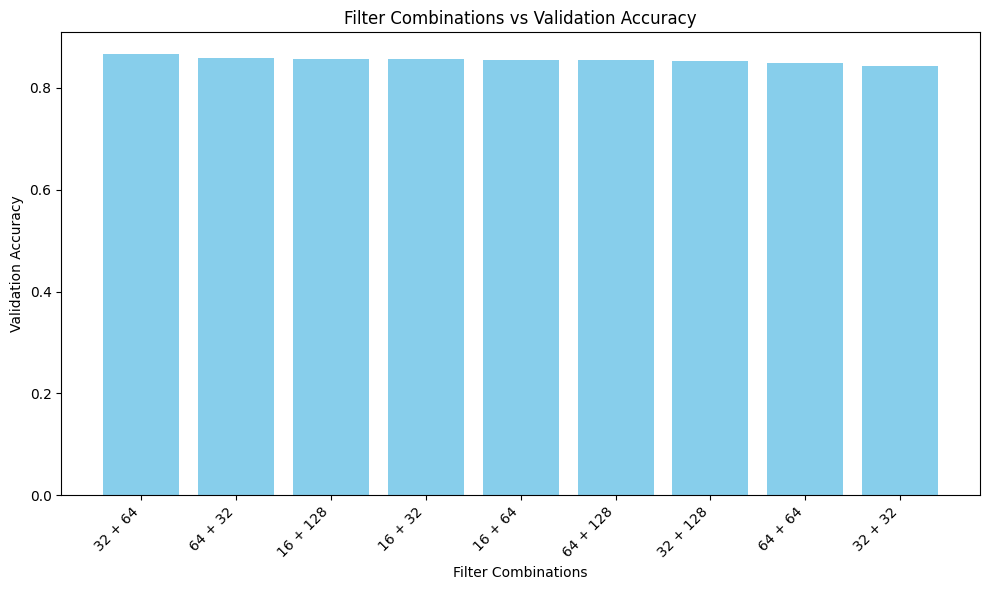

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import LeakyReLU  # Import LeakyReLU class
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

# Load the Fashion MNIST dataset (reduced size for faster training)
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Preprocess the data (normalize and reshape)
# Use only 15000 samples for training and 3000 for testing
train_images = train_images[:15000] / 255.0
train_labels = train_labels[:15000]  # Make sure labels match the reduced size of images
test_images = test_images[:3000] / 255.0
test_labels = test_labels[:3000]  # Make sure labels match the reduced size of images

train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Define hyperparameters for filters in convolutional layers
HP_FILTERS_1 = hp.HParam('filters_1', hp.Discrete([16, 32, 64]))
HP_FILTERS_2 = hp.HParam('filters_2', hp.Discrete([32, 64, 128]))

# Log directory for TensorBoard
LOG_DIR = "logs/hparam_tuning_filters/"

# Function to build the model with variable filters for the first two Conv layers
def build_model(hparams):
    model = models.Sequential([
        layers.Conv2D(hparams[HP_FILTERS_1], (3, 3), activation=LeakyReLU(), input_shape=(28, 28, 1)),  # Use LeakyReLU class
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(hparams[HP_FILTERS_2], (3, 3), activation='relu'),  # Keep ReLU as a string
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),  # Keep the third conv layer fixed
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  # Keep dense layer fixed
        layers.Dense(10, activation='softmax')  # Output layer (Softmax activation)
    ])

    model.compile(
        optimizer='adam',  # Use Adam optimizer from Q2(a)
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Function to run and log the training for each combination of filters
def run_experiment(hparams, session_num):
    model = build_model(hparams)
    history = model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))

    accuracy = history.history['val_accuracy'][-1]  # Validation accuracy from the last epoch
    return accuracy

# Explore different combinations of filters
results = []
filters_1_options = [16, 32, 64]
filters_2_options = [32, 64, 128]
session_num = 0

for filters_1 in filters_1_options:
    for filters_2 in filters_2_options:
        print(f"--- Starting trial: Filters 1={filters_1}, Filters 2={filters_2} ---")
        hparams = {
            HP_FILTERS_1: filters_1,
            HP_FILTERS_2: filters_2
        }

        # Run the experiment with the current filter combination
        accuracy = run_experiment(hparams, session_num)
        results.append((filters_1, filters_2, accuracy))
        session_num += 1

# Sort results by highest validation accuracy
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the sorted results (best configurations first)
print("\n--- Sorted Results (Best to Worst) ---")
for result in sorted_results:
    print(f"Filters 1: {result[0]}, Filters 2: {result[1]} -> Validation Accuracy: {result[2]*100:.2f}%")

# Best configuration
best_config = sorted_results[0]
print(f"\nBest configuration: Filters 1={best_config[0]}, Filters 2={best_config[1]} with Validation Accuracy: {best_config[2]*100:.2f}%")

# Save results in a table format (for the word/pdf report)
import pandas as pd

# Create a DataFrame from the results
df = pd.DataFrame(sorted_results, columns=['Filters 1', 'Filters 2', 'Validation Accuracy'])
df.to_csv('filter_results.csv', index=False)

# Plot bar chart of all filter combinations
filter_combinations = [f'{x[0]} + {x[1]}' for x in sorted_results]
accuracies = [x[2] for x in sorted_results]

plt.figure(figsize=(10, 6))
plt.bar(filter_combinations, accuracies, color='skyblue')
plt.xlabel('Filter Combinations')
plt.ylabel('Validation Accuracy')
plt.title('Filter Combinations vs Validation Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('filter_combinations_accuracy.png')
plt.show()
